# Hashtags Extraction and News Sorting

This notebook introduces the strategy of hashtags extraction for news, 

## Load News
Load news from News-API, remember to set environment variable `NEWSAPI_KEY` first. You can get your key from https://newsapi.org/

In [1]:
import pandas as pd
from wi_news.algorithms.get_news import get_news

pd.set_option('display.max_colwidth', None)

articles = get_news('Hong Kong')['articles']
df = pd.DataFrame(articles)
df

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': 'bbc-news', 'name': 'BBC News'}",https://www.facebook.com/bbcnews,Hong Kong passes tough security law,"Authorities say Article 23 is necessary for stability, but critics fear it will further erode civil liberties.",https://www.bbc.co.uk/news/world-asia-china-68594448,https://ichef.bbci.co.uk/news/1024/branded_news/0E83/production/_115651730_breaking-promo-976.png,2024-03-19T11:03:03Z,"Hong Kong has passed a tough security law which authorities say is necessary for stability, but which critics fear will further erode civil liberties.\r\nArticle 23 targets new offences like external i… [+3973 chars]"
1,"{'id': 'bbc-news', 'name': 'BBC News'}",https://www.facebook.com/bbcnews,Hong Kong’s new law is 'final nail in coffin' - critics,"Beijing and Hong Kong defend the controversial law, saying it is necessary for the city's stability.",https://www.bbc.co.uk/news/world-asia-china-68613249,https://ichef.bbci.co.uk/news/1024/branded_news/658C/production/_132969952_gettyimages-1214821212-1.jpg,2024-03-20T06:57:44Z,"Scores of international public figures have criticised Hong Kong's tough new security law, calling it yet another ""devastating blow"" for freedom. \r\nHong Kong's pro-Beijing parliament unanimously pass… [+4440 chars]"
2,"{'id': None, 'name': 'MacRumors'}",Juli Clover,Philips Hue Sync TV App for Samsung TVs Gets Subscription Option and Music Mode,"Philips Hue parent company Signify today announced an expanded relationship with Samsung, bringing the Philips Hue Sync TV app to additional countries, adding a Music Mode, and introducing a monthly subscription option.\n\n\n\n\n\nAs of last year, Samsung TV owners…",https://www.macrumors.com/2024/03/26/samsung-philips-hue-subscription-sync-app/,https://images.macrumors.com/t/B1ZsxzKcDA-dirWq3pGFhnym228=/2000x/article-new/2024/03/samsung-philips-hue-sync.jpg,2024-03-26T13:00:00Z,"Philips Hue parent company Signify today announced an expanded relationship with Samsung, bringing the Philips Hue Sync TV app to additional countries, adding a Music Mode, and introducing a monthly … [+1434 chars]"
3,"{'id': None, 'name': 'MacRumors'}",Tim Hardwick,AirPods Case With Touchscreen Knock-Off Copies Apple Patent,"Apple registers many patents most of which never see the light of day as consumer products – officially, that is. One burgeoning knock-off merchant in China has apparently taken cues from an idea Apple had in 2021 for AirPods featuring a case with a built-in …",https://www.macrumors.com/2024/03/14/airpods-case-with-touchscreen-knock-off/,https://images.macrumors.com/t/3TCGkxhtTZIpcoLYEPQzutjb-rc=/1920x/article-new/2023/04/AirPods-Pro-Case-With-Screen.jpg,2024-03-14T11:29:29Z,"Apple registers many patents most of which never see the light of day as consumer products officially, that is. One burgeoning knock-off merchant in China has apparently taken cues from an idea Appl… [+2363 chars]"
4,"{'id': None, 'name': 'NPR'}",John Ruwitch,Radio Free Asia closes its Hong Kong operation over safety concerns for its staff,U.S. government-funded Radio Free Asia is closing its Hong Kong operation after the city enacted a tough new national security law known locally as Article 23.,https://www.npr.org/2024/03/30/1241824311/radio-free-asia-closes-hong-kong-office,https://media.npr.org/assets/img/2024/03/30/gettyimages-1249409455_wide-523bfb7bf09c675223bf7d3141ad72e9ba9cfc75-s1400-c100.jpg,2024-03-30T06:13:45Z,"A view of the Hong Kong skyline is pictured before the lights were turned off to mark the Earth Hour environmental campaign on March 25, 2023.\r\nBertha Wang/AFP via Getty Images\r\nU.S. government-funde… [+2728 chars]"
...,...,...,...,...,...,...,...,...
95,"{'id': None, 'name': 'Forbes'}","Brendan Ahern, Senior Contributor, \n Brendan Ahern, Senior Contributor\n https://www.forbes.com/sites/brendanahern/","China Market Update: Meituan Crushes Analyst Estimates, Alibaba’s Must-Read Regulatory Filing, Week In Review",

## Preprocessing and Vectorization

The preprocess function extracts needed information from the raw articles, including text (merged by the title, description and content), lemma (convert from text), vector, hashtags_pool (will introduce later), and time of publishing.

In [2]:
from wi_news.algorithms.vectorization import preprocess


data = [preprocess(x) for x in articles]
data[0]

Article(raw={'source': {'id': 'bbc-news', 'name': 'BBC News'}, 'author': 'https://www.facebook.com/bbcnews', 'title': 'Hong Kong passes tough security law', 'description': 'Authorities say Article 23 is necessary for stability, but critics fear it will further erode civil liberties.', 'url': 'https://www.bbc.co.uk/news/world-asia-china-68594448', 'urlToImage': 'https://ichef.bbci.co.uk/news/1024/branded_news/0E83/production/_115651730_breaking-promo-976.png', 'publishedAt': '2024-03-19T11:03:03Z', 'content': 'Hong Kong has passed a tough security law which authorities say is necessary for stability, but which critics fear will further erode civil liberties.\r\nArticle 23 targets new offences like external i… [+3973 chars]'}, text='Hong Kong passes tough security law. Authorities say Article 23 is necessary for stability, but critics fear it will further erode civil liberties.. Hong Kong has passed a tough security law which authorities say is necessary for stability, but which critics 

## Hashtags Extraction

### Prepare the Pool

#### The Defination of Keywords

[The Five Ws](wikipedia)\[1\] is an important rule in journalism. If we want to extract some keywords for the news, the most promising method is that try to answer 2 of the 5 Ws: "Who" and "What", the subjects and the objects in a sentence. We can use the dependency parsing\[2\] to achieve this target. 

Let's take a example: "Hong Kong passes tough security law. Authorities say Article 23 is necessary for stability, but critics fear it will further erode civil liberties.. Hong Kong has passed a tough security law which authorities say is necessary for stability, but which critics fear will further erode civil liberties. Article 23 targets new offences like external i…"

The dependent tree of the first sentence, the Ws should be "Hong Kong" (subject) and "security law" (object).
```
passes VERB ROOT 
├── . PUNCT punct 
├── Kong PROPN nsubj 
│   └── Hong PROPN compound 
└── law NOUN dobj 
    ├── security NOUN compound 
    └── tough ADJ amod 
```

The second one is more complex, the Ws are "authority" (subject), "critic" (subject), "civil_liberty" (object), "article_23" (subject), and "stability" (object).
```
say VERB ROOT stopword
├── , PUNCT punct 
├── Authorities NOUN nsubj 
├── but CCONJ cc stopword
├── fear VERB conj 
│   ├── .. PUNCT punct 
│   ├── critics NOUN nsubj 
│   └── erode VERB ccomp 
│       ├── further ADV advmod stopword
│       ├── it PRON nsubj stopword
│       ├── liberties NOUN dobj 
│       │   └── civil ADJ amod 
│       └── will AUX aux stopword
└── is AUX ccomp stopword
    ├── Article NOUN nsubj 
    │   └── 23 NUM nummod 
    ├── for ADP prep stopword
    │   └── stability NOUN pobj 
    └── necessary ADJ acomp 
```

The third sentence is from the article's content, which is similar with the second one from the description. The keywords are "Hong_Kong" (subject), "critic" (Who, *nsubj*), "civil_liberty" (What, *dobj*), "security_law" (object), "stability" (object), "authority" (subject).
```
passed VERB ROOT 
├── , PUNCT punct 
├── . PUNCT punct 
├── Kong PROPN nsubj 
│   └── Hong PROPN compound 
├── but CCONJ cc stopword
├── fear VERB conj 
│   ├── critics NOUN nsubj 
│   └── erode VERB ccomp 
│       ├── further ADV advmod stopword
│       ├── liberties NOUN dobj 
│       │   └── civil ADJ amod 
│       ├── which PRON nsubj stopword
│       └── will AUX aux stopword
├── has AUX aux stopword
└── law NOUN dobj 
    ├── a DET det stopword
    ├── say VERB relcl stopword
    │   ├── authorities NOUN nsubj 
    │   └── is AUX ccomp stopword
    │       ├── for ADP prep stopword
    │       │   └── stability NOUN pobj 
    │       ├── necessary ADJ acomp 
    │       └── which PRON nsubj stopword
    ├── security NOUN compound 
    └── tough ADJ amod 
```

The fourth is not a complete sentence, but we can still try to extract "article_23" (subject), "new_offence" (object).

So the keywords pool with word frequencies of this article is

1. Hong_Kong, 2
2. security_law, 2
3. critic, 2
4. authority, 2
5. stability, 2
6. article_23, 2
7. civil_liberty, 2
8. new_offence, 1


#### Steps to Extract Keywords

We can generate the steps to extract keywords based on the the observation above:

1. split the document into sentences.
2. build the dependency tree for each sentence.
3. locate all of the non-stopword subject and object in the sentence, and their conjuncts, as our targets.
4. for every target, extract modifiers from their child nodes recursively, then we have the subtree from the target.
5. sort the subtree by tokens' positions and filter out the stopwords.
6. cut the prefix modifiers for compound words (for example, "security law" is a unique compound word, we don't need the "tough" as its prefix).
7. connect the sorted and filtered subtree as our keyword. 

#### Special Rule for Verb Root

The general extraction rule misses the information of the event itself. As an instance, if we apply the rules above on “John reads a book”, the extracted keywords are “John” and “book”. However, we have no idea about what John does for the book unless we include the event “reading”. This can be solved by compounding the direct object “book” and the verb’s gerund form “reading”. To be cautious, we only perform this special rule for the dependency root of a sentence, which is most promising to be the event.

Let's try the these step on a more complex case.


In [3]:
import spacy
from wi_news.algorithms.hashtags import KeywordsExtractor


nlp = spacy.load("en_core_web_md")
text = "Snøhetta Creates First Art Fair Installation At Art Basel Hong Kong. Award-winning practice Snøhetta crafts a sculptural space inspired by Victoria Harbour at Art Basel Hong Kong 2024."
doc = nlp(text)


for sent in doc.sents:
    extractor = KeywordsExtractor()
    extractor.find(sent)
    print('-' * 20)
    print(sent)
    print('\r')
    print(extractor.tree_.show(stdout=False))
    print(extractor.pool_)


--------------------
Snøhetta Creates First Art Fair Installation At Art Basel Hong Kong.

Creates VERB ROOT 
├── . PUNCT punct 
├── At ADP prep stopword
│   └── Kong PROPN pobj 
│       ├── Basel PROPN compound 
│       │   └── Art PROPN compound 
│       └── Hong PROPN compound 
├── Installation NOUN dobj 
│   └── Fair PROPN compound 
│       ├── Art PROPN compound 
│       └── First PROPN compound stopword
└── Snøhetta NOUN nsubj 

['snøhetta', 'Art_Basel_Hong_Kong', 'Art_Fair_installation', 'installation_Creating']
--------------------
Award-winning practice Snøhetta crafts a sculptural space inspired by Victoria Harbour at Art Basel Hong Kong 2024.

crafts VERB ROOT 
├── . PUNCT punct 
├── Snøhetta PROPN compound 
├── practice NOUN compound 
│   └── winning VERB amod 
│       ├── - PUNCT punct 
│       └── Award NOUN npadvmod 
└── space NOUN dobj 
    ├── a DET det stopword
    ├── inspired VERB acl 
    │   ├── at ADP prep stopword
    │   │   └── Kong PROPN pobj 
    │   │      

The result looks fine, now we have a hashtags pool for each article. It's time to determine which ones should be the hashtags!

### TF-IDF

TF-IDF returns adjusted word frequencies, helping us to find keywords that can distinguish the articles. Moreover, the computation will be fast because we have extracted the keywords of each article (i.e. a smaller vocabulary). I also implemented a variants of the TF-IDF: TF-DF. The TF-DF aims to find the most common keywords in articles, which will help to extract hashtags for clusters.

In [4]:
# TF-IDF
from wi_news.algorithms.hashtags import extract_by_tfidf


%time hashtags = extract_by_tfidf(data, n_hashtags=3, method='tfidf')
hashtags[:10]

CPU times: user 1.33 ms, sys: 6.94 ms, total: 8.26 ms
Wall time: 7.94 ms


array([['Stability', 'Authority', 'Law_Passing'],
       ['Controversial_Law', 'International_Public_Figure',
        'Pro_-_Beijing_Parliament'],
       ['Music_Mode', 'Philips_Hue_Sync_Tv_App', 'Expand_Relationship'],
       ['Apple', 'Consumer_Product', 'Cue'],
       ['Hong_Kong_Operation', 'Operation_Closing', 'Radio_Free_Asia'],
       ['July_1_2019', 'Protester', 'Legislature'],
       ['Access', 'Severity_Bug', 'F5'],
       ['Suspect_Smuggle_Gold', 'Suspect_Gold', '10_Million'],
       ['Bitcoin_Etf_Approval', 'Fund_Manager', 'Green_Light'],
       ['World', 'Netflix', 'Paramount']], dtype='<U40')

In [5]:
# TF-DF
%time hashtags = extract_by_tfidf(data, n_hashtags=3, method='tfdf')
hashtags[:10]

CPU times: user 4.95 ms, sys: 3.26 ms, total: 8.22 ms
Wall time: 7.85 ms


array([['Hong_Kong', 'Security_Law', 'Article_23'],
       ['Hong_Kong', 'Security_Law', 'Critic'],
       ['Music_Mode', 'Philips_Hue_Sync_Tv_App', 'Expand_Relationship'],
       ['Apple', 'China', 'Light'],
       ['Hong_Kong_Operation', 'Operation_Closing', 'Radio_Free_Asia'],
       ['Hong_Kong', 'Legislature', 'July_1_2019'],
       ['Access', 'Severity_Bug', 'F5'],
       ['Hong_Kong', 'Gold', 'Cargo_Plane'],
       ['Hong_Kong', 'Fund_Manager', 'Bitcoin_Etf_Approval'],
       ['World', 'Netflix', '90']], dtype='<U40')

### Cosine Similarity

We can also compute the cosine similarity for from a article to its keywords and select the keywords with high cosine similarity as the hashtags. But computation time is a problem since we need to compute the vector for the article text and all of the keywords.

In [6]:
from wi_news.algorithms.hashtags import extract_by_cosine


%time hashtags = extract_by_cosine(data, n_hashtags=3)
hashtags[:10]

CPU times: user 6.16 s, sys: 2.22 ms, total: 6.17 s
Wall time: 6.16 s


array([['Offence_Targeting', 'Stability', 'Authority'],
       ['Stability', 'Beijing', 'Hong_Kong'],
       ['Subscription_Option', 'Subscription_Option', 'Option_Getting'],
       ['Patent_Registering', 'China', 'Cue_Taking'],
       ['Operation_Closing', 'Hong_Kong_Operation',
        'Environmental_Campaign'],
       ['Protester', 'Anti_-_Government_Protest', '2019_Protest'],
       ['Couple_Exploiting', 'Access_Selling',
        'U.S._Defense_Organization'],
       ['Suspect_Smuggler', 'Kilogram_Discovering',
        'Suspect_Smuggle_Gold'],
       ['Chinese_Overseas_Investment', 'Approval_Seeking',
        'Bitcoin_Etf_Approval'],
       ['Beginning', 'Universal_Pictures', 'Character']], dtype=object)

## News Sorting

Notice that we can not extract any hashtags from the news No.3, 4, and 10 (`index = [2, 3, 9]`). Let's see what these text are.

In [7]:
import numpy as np


data = np.asarray(data, object)
for d in data[[2, 3, 9]]:
    print(f'{d.text}\n')


Philips Hue Sync TV App for Samsung TVs Gets Subscription Option and Music Mode. Philips Hue parent company Signify today announced an expanded relationship with Samsung, bringing the Philips Hue Sync TV app to additional countries, adding a Music Mode, and introducing a monthly subscription option. As of last year, Samsung TV owners…. Philips Hue parent company Signify today announced an expanded relationship with Samsung, bringing the Philips Hue Sync TV app to additional countries, adding a Music Mode, and introducing a monthly … 

AirPods Case With Touchscreen Knock-Off Copies Apple Patent. Apple registers many patents most of which never see the light of day as consumer products – officially, that is. One burgeoning knock-off merchant in China has apparently taken cues from an idea Apple had in 2021 for AirPods featuring a case with a built-in …. Apple registers many patents most of which never see the light of day as consumer products officially, that is. One burgeoning knock-off

### Sort News by Cosine Similarity

Obviously these news are not relating to our keyword: **Hong Kong**. We should filter out those news from our list, or at least put them at the end of the list. I implemented text retrival methods, TF-IDF with n-grams (by default, n can be from 1 to 3) and sentence embeddings. I also showed the hashtags extracted by "TF-DF" to check whether the articles relates to our keyword.

In [8]:
# TF-IDF
from wi_news.algorithms.sort_news import NewsSorter


keyword = 'Hong Kong'

def extract_info(data, hashtags='tfi=df'):
    df = pd.DataFrame([{'title': d.raw['title'], 'description': d.raw['description'], 'time': d.time} for d in data])
    df.loc[:, 'hashtags'] = extract_by_tfidf(data, method=hashtags).tolist()
    return df

sorter = NewsSorter(keyword)
sorted_data = sorter.sort(data, method='tfidf', by_date=False)
extract_info(sorted_data, 'tfdf').iloc[:10]  # using tfdf extraction to check if the article is related to our keyword

,title,description,time,hashtags
0,Hong Kong jails 12 people for storming the legislature during 2019 protests,"Hundreds of protesters swarmed into the legislature the night of July 1, 2019 at the height of the anti-government protests.",2024-03-16 05:30:10+00:00,"[Hong_Kong, Legislature, Protester]"
1,Hong Kong’s new law is 'final nail in coffin' - critics,"Beijing and Hong Kong defend the controversial law, saying it is necessary for the city's stability.",2024-03-20 06:57:44+00:00,"[Hong_Kong, Security_Law, Critic]"
2,Closer Look at the Galleries Exhibited During Art Basel Hong Kong 2024,"Art Basel Hong Kong 2024 has kicked off in full force. The international art fair has landed in Hong Kong, bringing a global group of art aficionados to the vibrant Asian city. Hypebeast was on the ground to observe the 242 galleries from 40 countries at Art …",2024-03-28 13:13:40+00:00,"[Hong_Kong, Global_Group, International_Art_Fair]"
3,Hong Kong Faces Property Problems: All Very Much Of Beijing’s Making,Beijing’s mismanagement of Hong Kong has stolen all that had made the city an attractive place to do business and so stolen from China much of the city’s value.,2024-03-18 14:43:19+00:00,"[Hong_Kong, Getty_Images, China]"
4,China Market Update: Alibaba Joins Tencent’s Buyback Bonanza,Asian equities were mixed as Hong Kong and Taiwan outperformed.,2024-04-02 14:09:30+00:00,"[Hong_Kong, Taiwan, Asian_Equity]"
5,Hong Kong’s Zero-Opposition Legislature Aims To Up Oppression With New ‘National Security’ Law,"A gentleman’s agreement with the UK following years of colonialism has given rise to another form of oppression. China took over Hong Kong in 1997, promising to stay out of the day-to-day business of governing Hong Kong for 50 years. Not even halfway through …",2024-03-15 22:31:00+00:00,"[Hong_Kong, Oppression, Year]"
6,"What is Article 23, Hong Kong’s new draconian national security law?",Passing of new national security law described as 'very dark day' for civil liberties in Hong Kong.,2024-03-19 15:37:43+00:00,"[Hong_Kong, Security_Law, Article_23]"
7,Duddell Street Lamps in Hong Kong,"In bustling Hong Kong, where infrastructure and people are adapting and evolving every second, Duddell Street is a time capsule to the city's British colonial past. The last of their kind, these gas lamps serve as a reminder of Hong Kong's bygone era. \nStill …",2024-03-15 19:30:00+00:00,"[Hong_Kong, People, Second]"
8,Suspected smugglers were caught trying to hide $10 million of gold by painting it silver and disguising it as machinery on a cargo plane,"It is the largest gold-smuggling case on record in Hong Kong, according to officials.",2024-04-09 10:44:11+00:00,"[Hong_Kong, Gold, 146_Kilogram]"
9,Snøhetta Creates First Art Fair Installation At Art Basel Hong Kong,Award-winning practice Snøhetta crafts a sculptural space inspired by Victoria Harbour at Art Basel Hong Kong 2024,2024-03-28 07:27:55+00:00,"[Art_Basel_Hong_Kong, Art_Basel_Hong_Kong_2024, Lighting]"


In [9]:
# sentence embeddings
sorted_data = sorter.sort(data, method='embeddings', by_date=False)
extract_info(sorted_data, 'tfdf').iloc[:10]

,title,description,time,hashtags
0,Hong Kong passes tough new national security law,Hong Kong has passed a new national security law that critics fear will further erode civil liberties.,2024-03-19 17:32:55+00:00,"[Hong_Kong, Security_Law, Law_Passing]"
1,Hong Kong’s new law is 'final nail in coffin' - critics,"Beijing and Hong Kong defend the controversial law, saying it is necessary for the city's stability.",2024-03-20 06:57:44+00:00,"[Hong_Kong, Security_Law, Critic]"
2,Hong Kong Passes Article 23 National Security Law,"Hong Kong’s lawmakers have unanimously passed a national security legislation, which will come into effect on March 23. The national security bill, also known as Article 23, covers five categories of crimes in Hong Kong, which include a total of 39 new nation…",2024-03-20 08:31:16+00:00,"[Hong_Kong, Article_23, Legislation_Passing]"
3,Hong Kong passes tough security law,"Authorities say Article 23 is necessary for stability, but critics fear it will further erode civil liberties.",2024-03-19 11:03:03+00:00,"[Hong_Kong, Security_Law, Article_23]"
4,Hong Kong makes largest-ever gold smuggling bust,"Authorities seized 146kg of the precious metal, which was headed for Japan disguised as machine parts.",2024-04-08 11:47:53+00:00,"[Hong_Kong, Machine_Part, Gold_Smuggling_Bust]"
5,Hong Kong FDC Hands Out First Round Of Streaming Content Development Grants,"Hong Kong Film Development Council (HKFDC) has announced the first ten projects to receive grants under its Content Development Scheme for Streaming Platforms. The ten projects, which will now enter phase two of the scheme, include series to be directed and/o…",2024-03-13 15:20:36+00:00,"[Project, Content_Development_Scheme, Grant]"
6,Hong Kong jails 12 for storming legislature in 2019,Defendants jailed for terms between four and seven years after being found guilty of rioting.,2024-03-16 06:40:27+00:00,"[Hong_Kong, Year, Legislature]"
7,China Market Update: Yellen’s Trip Helps Mend US-China Relations,"Asian equities were mixed but mostly higher as Mainland China fell while Indonesia and Thailand were on holiday. Hong Kong bounced around the room to manage a small gain for the session, though growth stocks underperformed.",2024-04-08 15:56:41+00:00,"[Hong_Kong, Mainland_China, Small_Gain]"
8,Hong Kong jails 12 people for storming the legislature during 2019 protests,"Hundreds of protesters swarmed into the legislature the night of July 1, 2019 at the height of the anti-government protests.",2024-03-16 05:30:10+00:00,"[Hong_Kong, Legislature, July_1_2019]"
9,Hong Kong promises its latest national security law is not a ban on social media,"Trust us – we're the government\nOn Tuesday, Hong Kong's legislature unanimously passed the city's latest controversial national security legislation, otherwise known as Article 23.…",2024-03-21 04:01:06+00:00,"[Hong_Kong, Article_23, Legislature]"


Problem solved! Now all of the top-10 articles invole our keyword. But how about the time? We need to deliver the up-to-date articles to the users because timeliness is also an important. So I decides an "Days-Decay" stategy: for the articles that published two or more days ago, decay their scores (i.e. cosine similarities between query's vector and contents' vectors) with a variable "days-decay" based on days. The day-decay can be calculated from the formula below, days is the interval from the published date to today:

$$ decay = log_2(max(days + 1, 2))$$

The score to sort is:

$$ score' = \frac{score}{decay} $$

Thus, for the articles published today or one day ago, the decay factor will be 1 (i.e. no decay). For the older news, the decay will grow logarithmically. The news with an extremely high relation can still exposure to the users.

In [10]:
sorter.date

datetime.datetime(2024, 4, 14, 4, 7, 3, 484871, tzinfo=<UTC>)

In [11]:
sorted_data = sorter.sort(data, method='embeddings', by_date=True)
extract_info(sorted_data, 'tfdf').iloc[:10]

,title,description,time,hashtags
0,Chinese fund managers seek Bitcoin ETF approval in Hong Kong,"Hong Kong, a prominent global financial hub and a gateway for Chinese overseas investments, is poised to green-light a spot… Continue reading Chinese fund managers seek Bitcoin ETF approval in Hong Kong\nThe post Chinese fund managers seek Bitcoin ETF approval…",2024-04-12 16:17:06+00:00,"[Hong_Kong, Fund_Manager, Bitcoin_Etf_Approval]"
1,Hong Kong makes largest-ever gold smuggling bust,"Authorities seized 146kg of the precious metal, which was headed for Japan disguised as machine parts.",2024-04-08 11:47:53+00:00,"[Hong_Kong, Machine_Part, Gold_Smuggling_Bust]"
2,China Market Update: Yellen’s Trip Helps Mend US-China Relations,"Asian equities were mixed but mostly higher as Mainland China fell while Indonesia and Thailand were on holiday. Hong Kong bounced around the room to manage a small gain for the session, though growth stocks underperformed.",2024-04-08 15:56:41+00:00,"[Hong_Kong, Mainland_China, Small_Gain]"
3,China Market Update: Hong Kong Rises Despite Fitch Outlook Change,"Asian equities were mixed overnight ahead of US inflation data, which came in ahead of estimates, as Hong Kong outperformed significantly.",2024-04-10 14:45:16+00:00,"[Hong_Kong, Inflation_Datum, Estimate]"
4,Video: Experimental drone drastically boosts runtime ... by pogo-hopping,"By hopping like a person on a pogo stick, a modified aerial drone can operate for almost an hour as opposed to several minutes if it simply flew. Descendants of the aircraft could one day find use in applications such as wildlife monitoring, crop inspection o…",2024-04-12 20:10:20+00:00,"[Hour, Minute, Aircraft]"
5,China Market Update: Alibaba Joins Tencent’s Buyback Bonanza,Asian equities were mixed as Hong Kong and Taiwan outperformed.,2024-04-02 14:09:30+00:00,"[Hong_Kong, Taiwan, Asian_Equity]"
6,Hong Kong passes tough new national security law,Hong Kong has passed a new national security law that critics fear will further erode civil liberties.,2024-03-19 17:32:55+00:00,"[Hong_Kong, Security_Law, Law_Passing]"
7,Hong Kong’s new law is 'final nail in coffin' - critics,"Beijing and Hong Kong defend the controversial law, saying it is necessary for the city's stability.",2024-03-20 06:57:44+00:00,"[Hong_Kong, Security_Law, Critic]"
8,Hong Kong Passes Article 23 National Security Law,"Hong Kong’s lawmakers have unanimously passed a national security legislation, which will come into effect on March 23. The national security bill, also known as Article 23, covers five categories of crimes in Hong Kong, which include a total of 39 new nation…",2024-03-20 08:31:16+00:00,"[Hong_Kong, Article_23, Legislation_Passing]"
9,Louise Giovanelli Muses on Ancient Greek 'Maenads' in New Exhibition,"British artist Louise Giovanelli has unveiled a new solo exhibition at White Cube Hong Kong. Based in Manchester, Giovanelli creates luminous paintings that oscillate between figuration and abstraction, representation and materiality, as she draws from art hi…",2024-04-10 12:13:15+00:00,"[Solo_Exhibition, Exhibition_Unveiling, Giovanelli]"


## Extract Hashtags for Clusters

In our pipeline, when the user search for some news, the articles will be fetched from News-API, and clustered after being classified into different categories. News in different clusters should relate to different topic so it's meaningful to extract hashtags for different clusters.

First, let's cluster our Hong Kong news:

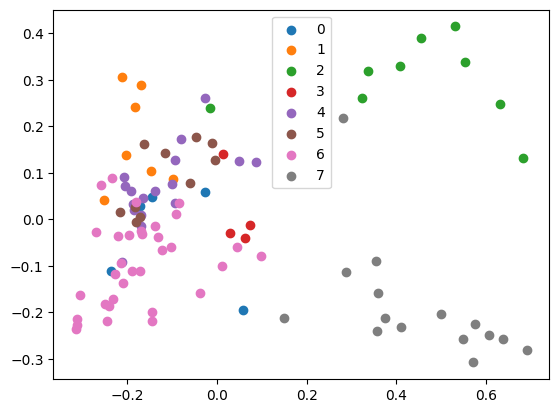

In [27]:
from matplotlib import pyplot as plt
from wi_news.algorithms.clustering import cluster_data, reduce_dimensionality


model = cluster_data(sorted_data)
labels = model.labels_
samples = reduce_dimensionality([d.vector for d in sorted_data])

for lab in np.unique(labels):
    plt.scatter(*samples[lab == labels].T, label=lab)
plt.legend()

In [28]:
df = extract_info(sorted_data, 'tfdf')
df.loc[:, 'cluster'] = labels
df.iloc[:10]

,title,description,time,hashtags,cluster
0,Chinese fund managers seek Bitcoin ETF approval in Hong Kong,"Hong Kong, a prominent global financial hub and a gateway for Chinese overseas investments, is poised to green-light a spot… Continue reading Chinese fund managers seek Bitcoin ETF approval in Hong Kong\nThe post Chinese fund managers seek Bitcoin ETF approval…",2024-04-12 16:17:06+00:00,"[Hong_Kong, Fund_Manager, Bitcoin_Etf_Approval]",7
1,Hong Kong makes largest-ever gold smuggling bust,"Authorities seized 146kg of the precious metal, which was headed for Japan disguised as machine parts.",2024-04-08 11:47:53+00:00,"[Hong_Kong, Machine_Part, Gold_Smuggling_Bust]",7
2,China Market Update: Yellen’s Trip Helps Mend US-China Relations,"Asian equities were mixed but mostly higher as Mainland China fell while Indonesia and Thailand were on holiday. Hong Kong bounced around the room to manage a small gain for the session, though growth stocks underperformed.",2024-04-08 15:56:41+00:00,"[Hong_Kong, Mainland_China, Small_Gain]",2
3,China Market Update: Hong Kong Rises Despite Fitch Outlook Change,"Asian equities were mixed overnight ahead of US inflation data, which came in ahead of estimates, as Hong Kong outperformed significantly.",2024-04-10 14:45:16+00:00,"[Hong_Kong, Inflation_Datum, Estimate]",2
4,Video: Experimental drone drastically boosts runtime ... by pogo-hopping,"By hopping like a person on a pogo stick, a modified aerial drone can operate for almost an hour as opposed to several minutes if it simply flew. Descendants of the aircraft could one day find use in applications such as wildlife monitoring, crop inspection o…",2024-04-12 20:10:20+00:00,"[Hour, Minute, Aircraft]",4
5,China Market Update: Alibaba Joins Tencent’s Buyback Bonanza,Asian equities were mixed as Hong Kong and Taiwan outperformed.,2024-04-02 14:09:30+00:00,"[Hong_Kong, Taiwan, Asian_Equity]",2
6,Hong Kong passes tough new national security law,Hong Kong has passed a new national security law that critics fear will further erode civil liberties.,2024-03-19 17:32:55+00:00,"[Hong_Kong, Security_Law, Law_Passing]",7
7,Hong Kong’s new law is 'final nail in coffin' - critics,"Beijing and Hong Kong defend the controversial law, saying it is necessary for the city's stability.",2024-03-20 06:57:44+00:00,"[Hong_Kong, Security_Law, Critic]",7
8,Hong Kong Passes Article 23 National Security Law,"Hong Kong’s lawmakers have unanimously passed a national security legislation, which will come into effect on March 23. The national security bill, also known as Article 23, covers five categories of crimes in Hong Kong, which include a total of 39 new nation…",2024-03-20 08:31:16+00:00,"[Hong_Kong, Article_23, Legislation_Passing]",7
9,Louise Giovanelli Muses on Ancient Greek 'Maenads' in New Exhibition,"British artist Louise Giovanelli has unveiled a new solo exhibition at White Cube Hong Kong. Based in Manchester, Giovanelli creates luminous paintings that oscillate between figuration and abstraction, representation and materiality, as she draws from art hi…",2024-04-10 12:13:15+00:00,"[Solo_Exhibition, Exhibition_Unveiling, Giovanelli]",4


Then I implemented a function `extract_for_clusters` for hashtags of clusters. It first extracts the hashtags by *TF-DF* from articles grouped by clusters. These hashtags will then be merged into the corresponding cluster's hashtag pool. Finally, use *TF-IDF* to extract hashtags for each cluster.

The result seems feasible, the cluster 7 is about the "National Security" law.

In [29]:
from wi_news.algorithms.hashtags import extract_for_clusters


hashtags = extract_for_clusters(sorted_data, labels, n_hashtags=3)
for label in np.unique(labels):
    center = model.cluster_centers_[label]
    print('-' * 5, label, ':', ', '.join(hashtags[label]), '-' * 5)
    for title in sorter.get_title(
        sorted(sorted_data[label == labels], key=lambda x: np.linalg.norm(x.vector - center))
    )[:5]:
        print(title)
    print('\n')

----- 0 : China, Performance_Polo, Nubia -----
AirPods Case With Touchscreen Knock-Off Copies Apple Patent
iPhone 16 Pro's A18 Pro Chip Rumored to Boost AI, Retain 6-Core GPU
Like-New Porsche 918 "Weissach" Spyder Surfaces at Auction
nubia Flip global pre-orders open as well
2015 Porsche 918 Weissach Spyder


----- 1 : Editor, Credibility, Article -----
Researchers develop mechanism of electrical 180° switching of Néel vector in spin-splitting antiferromagnet
Research reveals significant effects of onscreen instructors during video classes in aiding student learning
Bifunctional catalyst enables high-performance batteries for sustainable energy storage
Sensitive interventions to catalyze China's net-zero transition in energy and transport
Unraveling the behavior of nanoconfined water and ice in extreme conditions


----- 2 : Asian_Equity, Hong_Kong, Mainland_China -----
China Market Update: Meituan Crushes Analyst Estimates, Alibaba’s Must-Read Regulatory Filing, Week In Review
China M

## Reference

1. Wikipedia, *Five Ws*. https://en.wikipedia.org/wiki/Five_Ws
2. emorynlp, *Deep Dependency Guidelines*. https://emorynlp.github.io/ddr/doc/pages/overview.html